In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from pandas_ml_utils.ml.summary import ClassificationSummary, RegressionSummary
from pandas_ml_utils import FeaturesAndLabels, Model, KerasModel
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

automatically imported pandas_ml_utils 0.1.2


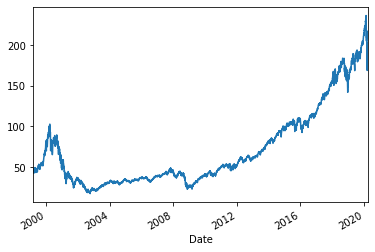

In [2]:
df = pd.fetch_yahoo("qqq")
df["Close"].plot()

count    5273.000000
mean        0.014701
std         0.009553
min         0.003392
25%         0.008274
50%         0.011169
75%         0.017773
max         0.057087
Name: stddev, dtype: float64

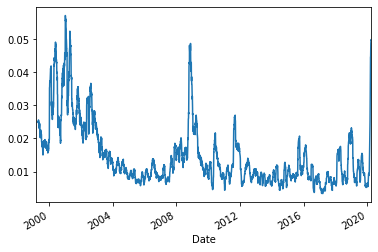

In [3]:
df["stddev"] = df["Close"].pct_change().rolling(30).std()
df["stddev"].plot()
df["stddev"].describe()

In [8]:
features_and_labels = PostProcessedFeaturesAndLabels(
    features=[
        lambda df: df.ta.candles_as_culb(volume=None, relative_close=True),
        lambda df: df["Volume"].ta.ma_ratio(period=20),
        lambda df: df["Close"].ta.log_returns()
    ],
    feature_post_processor=[
        lambda df: df.ta.rnn(90)
    ],
    labels=[
        df["Close"].pct_change().rolling(30).std().shift(-7)
    ]
)

(features, min_needed_samples), labels, target, sample_weights = df._.extract(features_and_labels)
features.tail()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
,close,close,close,close,close,close,close,close,close,close,...,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return,Close_log_return
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-19,0.006015,-0.030426,0.075826,-0.119783,0.084718,-0.091684,-0.043598,0.054463,-0.069467,-0.016861,...,-0.002188,-0.006043,0.001483,0.000792,0.007302,-0.000797,0.000249,0.002894,-0.001348,0.004001
2020-03-20,-0.039147,0.006015,-0.030426,0.075826,-0.119783,0.084718,-0.091684,-0.043598,0.054463,-0.069467,...,0.000647,-0.002188,-0.006043,0.001483,0.000792,0.007302,-0.000797,0.000249,0.002894,-0.001348
2020-03-23,0.000704,-0.039147,0.006015,-0.030426,0.075826,-0.119783,0.084718,-0.091684,-0.043598,0.054463,...,0.011724,0.000647,-0.002188,-0.006043,0.001483,0.000792,0.007302,-0.000797,0.000249,0.002894
2020-03-24,0.077438,0.000704,-0.039147,0.006015,-0.030426,0.075826,-0.119783,0.084718,-0.091684,-0.043598,...,0.001916,0.011724,0.000647,-0.002188,-0.006043,0.001483,0.000792,0.007302,-0.000797,0.000249
2020-03-25,-0.007405,0.077438,0.000704,-0.039147,0.006015,-0.030426,0.075826,-0.119783,0.084718,-0.091684,...,0.006995,0.001916,0.011724,0.000647,-0.002188,-0.006043,0.001483,0.000792,0.007302,-0.000797


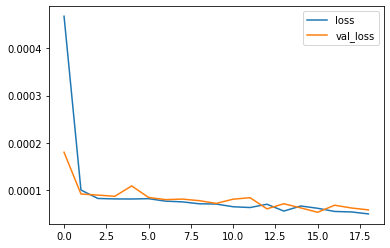

In [10]:
from pandas_ml_quant.keras.time_to_vec import Time2Vec as Time2Vec
from pandas_ml_utils.keras.callbacks import plot_losses

from keras.layers import Dense, Input, LSTM, Lambda, Concatenate
from keras.callbacks import EarlyStopping
from keras.models import Model
import tensorflow as tf

def model_provider():
    input_shape=(90, 2 + 4)
    inp = Input(input_shape)
    broad_cast = Lambda( lambda x: tf.split(x, num_or_size_splits=input_shape[-1], axis=-1))(inp)
    ds = []
    for bc in broad_cast:
        t2v = Time2Vec(64, input_shape=(input_shape[0], 1))(bc)
        lstm = LSTM(32)(t2v)
        ds.append(Dense(4)(lstm))
        
    conc = Concatenate()(ds)
    out = Dense(1)(conc)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='mse', optimizer='adam')

    return model

model_provider()

fit = df.model.fit(
    KerasModel(
        model_provider,
        features_and_labels,
        summary_provider=RegressionSummary,
        # keras args
        callbacks=[plot_losses(tf.keras.callbacks.Callback), lambda: EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=1,
        epochs=20,
        batch_size=128
    )
)

fit

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
from pandas_ml_utils.keras.callbacks import plot_losses
from pandas_ml_quant.keras.time_to_vec import tf_Time2Vec as Time2Vec

def model_provider():
    model = tf.keras.Sequential([
        Time2Vec(32, input_shape=(280, 1)),
        tf.keras.layers.LSTM(32, activation='tanh'),
        tf.keras.layers.Dense(16, activation='tanh'), 
        tfp.layers.DenseFlipout(7, kernel_posterior_fn=tfp.distributions.HalfCauchy()),
    ])

    model.compile(tf.keras.optimizers.Adam(), loss='mse')

    return model

model_provider()

fit = df.model.fit(
    KerasModel(
        model_provider,
        features_and_labels,
        summary_provider=RegressionSummary,
        # keras args
        callbacks=[plot_losses(tf.keras.callbacks.Callback)],
        verbose=1,
        epochs=20,
        batch_size=128
    )
)

fit

TypeError: __init__() missing 2 required positional arguments: 'loc' and 'scale'